In [1]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import chart_studio.plotly as ply
import cufflinks as cf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
cf.go_offline()

In [ ]:
df = yf.download('AAPL', start='2022-01-01', end='2022-12-31')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,180.190964,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,177.904083,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,173.171829,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,170.281021,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,170.449295,86709100


In [ ]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

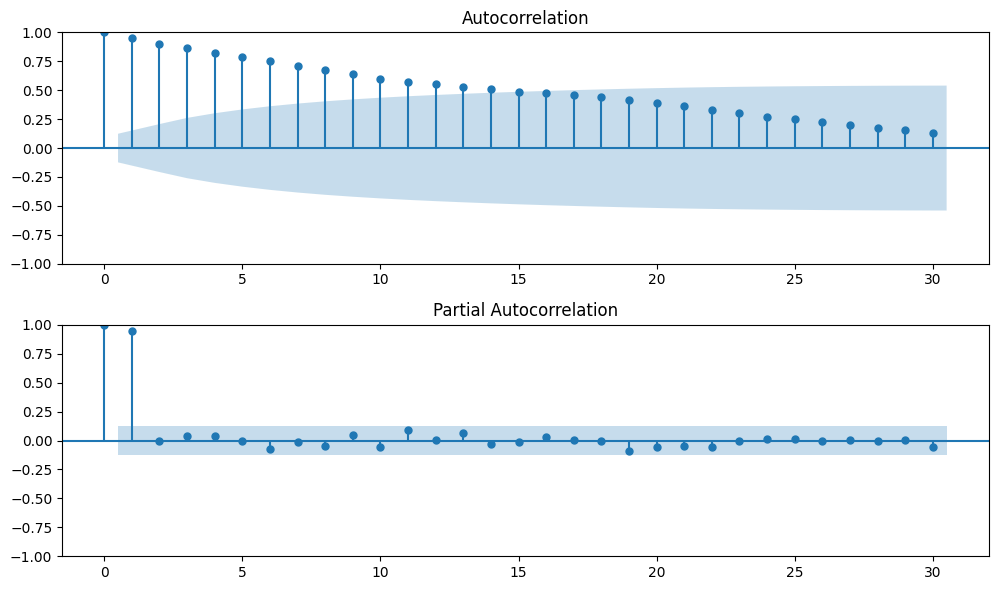

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plot_acf(df['Close'], lags=30, ax=plt.gca())
plt.subplot(2, 1, 2)
plot_pacf(df['Close'], lags=30, ax=plt.gca())
plt.tight_layout()
plt.show()

In [ ]:
# Results come out nonsensical since data is non seasonal. Try this with seasonal data
"""import plotly.offline as py
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period=1)
fig = result.plot()
fig.show()"""

"import plotly.offline as py\nfrom chart_studio.plotly import plot_mpl\nfrom statsmodels.tsa.seasonal import seasonal_decompose\nresult = seasonal_decompose(df['Close'], model='multiplicative', period=1)\nfig = result.plot()\nfig.show()"

In [ ]:
# Step 1: Checking Stationarity
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.1730059875108707
p-value: 0.21618816815441205
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}


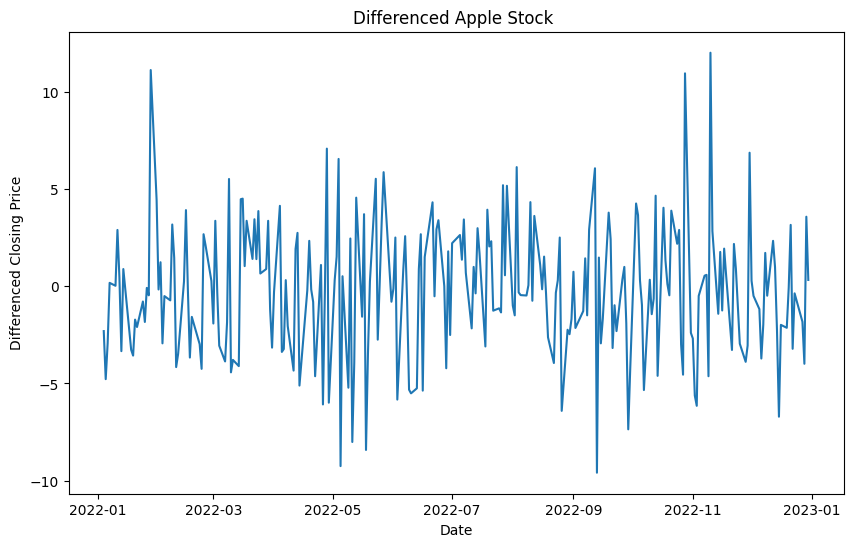

In [ ]:
# Differencing to make the time series stationary
df['Close_diff'] = df['Close'] - df['Close'].shift(1)
df['Close_diff'].dropna(how='any', inplace=True)

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df['Close_diff'])
plt.xlabel('Date')
plt.ylabel('Differenced Closing Price')
plt.title('Differenced Apple Stock ')
plt.show()

In [ ]:
cdiff = df['Close_diff'].drop(df.index[0])

In [ ]:
# Checking Stationarity again

# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(cdiff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -12.233497887342859
p-value: 1.0406869838213893e-22
Critical Values: {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}


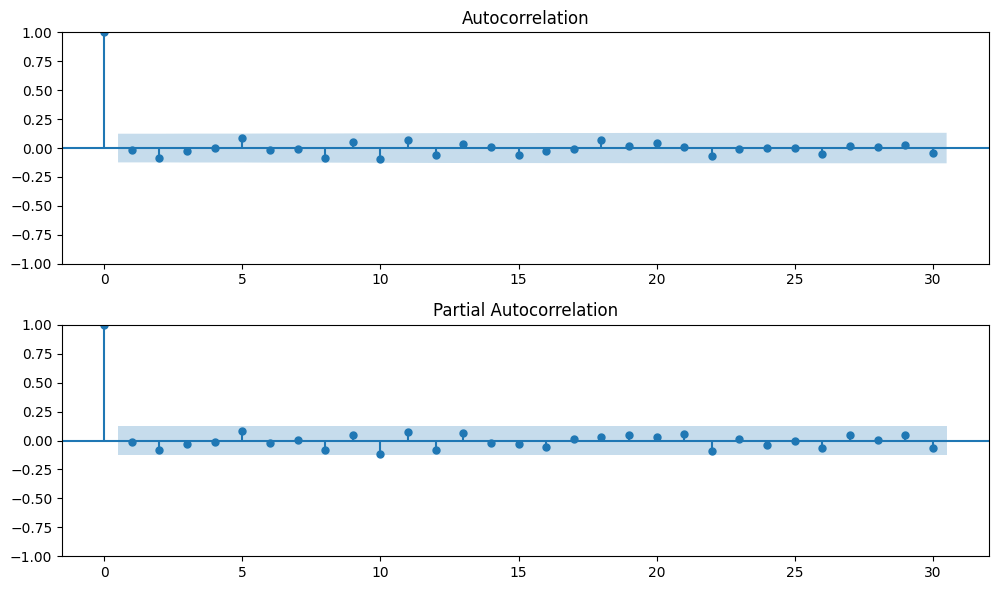

In [ ]:
#Plotting ACF and PACF for differenced data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plot_acf(cdiff, lags=30, ax=plt.gca())
plt.subplot(2, 1, 2)
plot_pacf(cdiff, lags=30, ax=plt.gca())
plt.tight_layout()
plt.show()

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.3 MB/s eta 0:00:00


In [ ]:
# Trying to find appropriate model
import pmdarima
from pmdarima import auto_arima

stepwise_model = auto_arima(df['Close'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False, stationary=False,
                           d=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(stepwise_model.aic())

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1325.891, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1327.824, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1327.811, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1324.826, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.474 seconds
1324.8260207246549


In [ ]:
# Train test split
train = df['Close'].loc['2022-01-01':'2022-11-30']
test = df['Close'].loc['2022-12-02':]

In [ ]:
# Train the model
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Forecasting
future_forecast = stepwise_model.predict(n_periods=20)

print(future_forecast)

230    148.029999
231    148.029999
232    148.029999
233    148.029999
234    148.029999
235    148.029999
236    148.029999
237    148.029999
238    148.029999
239    148.029999
240    148.029999
241    148.029999
242    148.029999
243    148.029999
244    148.029999
245    148.029999
246    148.029999
247    148.029999
248    148.029999
249    148.029999
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [ ]:
forecast_horizon = 20

In [ ]:
forecast_index = pd.date_range(start=df['Close'].index[-1], periods=forecast_horizon+1, freq='D')[1:]
forecast_df = pd.DataFrame({
    'Forecasted Values': predictions_array}, index=forecast_index)

print(forecast_df)

NameError: ignored

In [ ]:
# Create the predictions DataFrame
predictions = pd.DataFrame({
    'Date': pd.date_range('2022-12-01', periods=len(future_forecast), freq='D'),
    'Predicted': future_forecast
})

In [ ]:
print(predictions)

In [ ]:
# Set the 'Date' column as the index
predictions.set_index('Date', inplace=True)

In [ ]:
# Convert predictions to a one-dimensional NumPy array
predictions_array = predictions['Predicted'].values

# Print the one-dimensional NumPy array
print(predictions_array)

In [ ]:
# Remove the column label
predictions['Predicted'].name = None

In [ ]:
# Calculate differences (errors)
comparison_df = interpolated_actual_df - df_pred2


In [ ]:
df_actual = test.copy(deep=True)  # This is a deep copy

In [ ]:
# Create an extended date range covering the entire period
full_date_range = pd.date_range(start='2022-12-2', end='2022-12-20', freq='D')

# Reindex and interpolate actual data to match full date range
reindexed_actual_df = df_actual.reindex(full_date_range)
interpolated_actual_df = reindexed_actual_df.interpolate()

In [ ]:
df_pred = predictions.copy(deep=True)

In [ ]:
df_pred2 = df_pred.drop(df_pred.index[0])

In [ ]:
# Join actual and forecasted data
combined_df = pd.merge(interpolated_actual_df,df_pred2, left_index=True, right_index=True)

In [ ]:
# Calculate errors
combined_df['Error'] = combined_df['Close'] - combined_df['Predicted']

In [ ]:
# Visualize differences/errors using a line plot
plt.figure(figsize=(15, 6))
plt.plot(combined_df.index, combined_df['Error'], marker='o')
plt.title('Actual vs Forecasted Differences')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 7.0 MB/s eta 0:00:00


In [ ]:
from arch import arch_model
# Define the GARCH(1, 1) model
modelG = arch_model(train, vol='Garch', p=1, q=1)

# Fit the model
results = modelG.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1729.518160032001
Iteration:      2,   Func. Count:     12,   Neg. LLF: 857.5913389361212
Iteration:      3,   Func. Count:     17,   Neg. LLF: 857.0414993011923
Iteration:      4,   Func. Count:     22,   Neg. LLF: 855.2281164318979
Iteration:      5,   Func. Count:     27,   Neg. LLF: 855.0508244812689
Iteration:      6,   Func. Count:     32,   Neg. LLF: 854.860531743398
Iteration:      7,   Func. Count:     37,   Neg. LLF: 854.7800336605776
Iteration:      8,   Func. Count:     42,   Neg. LLF: 854.6617447398319
Iteration:      9,   Func. Count:     47,   Neg. LLF: 854.6017686752016
Iteration:     10,   Func. Count:     52,   Neg. LLF: 854.5870739788256
Iteration:     11,   Func. Count:     57,   Neg. LLF: 854.5852467580095
Iteration:     12,   Func. Count:     62,   Neg. LLF: 854.5832661555006
Iteration:     13,   Func. Count:     67,   Neg. LLF: 854.5832284807328
Iteration:     14,   Func. Count:     72,   Neg. LLF: 854.5832272

In [ ]:
print(results.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -854.583
Distribution:                  Normal   AIC:                           1717.17
Method:            Maximum Likelihood   BIC:                           1730.92
                                        No. Observations:                  230
Date:                Wed, Sep 20 2023   Df Residuals:                      229
Time:                        03:16:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           152.3820      3.230     47.184      0.000 [1.

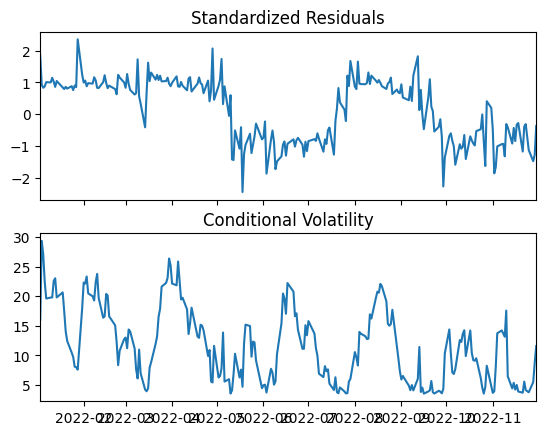

In [ ]:
# Plot standardized residuals
results.plot()

# Display the plot
plt.show()


In [ ]:
# Forecasting
future_forecast_garch = modelG.predict(n_periods=20)

print(future_forecast_garch)

AttributeError: ignored